In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Tanh, Module, BCELoss, NLLLoss, Softmax, KLDivLoss, HingeEmbeddingLoss
from torch.optim import SGD, Adam, RMSprop
from torch.nn.init import kaiming_uniform_, xavier_uniform_







class TorchDataset(Dataset):
    def __init__(self, csvData):
        self.X = csvData.values[:, :-1]
        self.y = csvData.values[:, -1]
        self.X = self.X.astype('float32')

        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def getDataSplits(self):
        trainSize = round(.7 * len(self.X))
        validationSize = round(.15 * len(self.X))
        testSize = len(self.X) - trainSize - validationSize
        return random_split(self, [trainSize, testSize, validationSize])






class Network(Module):
    def __init__(self):
        super(Network, self).__init__()

        self.hidden1 = Linear(34, 14)
        kaiming_uniform_(self.hidden1.weight)
        self.activation1 = hiddenLayerActivation()

        self.hidden2 = Linear(14, 12)
        kaiming_uniform_(self.hidden2.weight)
        self.activation2 = hiddenLayerActivation()

        self.hidden3 = Linear(12, 10)
        kaiming_uniform_(self.hidden3.weight)
        self.activation3 = hiddenLayerActivation()

        self.hidden4 = Linear(10, 8)
        kaiming_uniform_(self.hidden4.weight)
        self.activation4 = hiddenLayerActivation()

        self.hidden5 = Linear(8, 6)
        kaiming_uniform_(self.hidden5.weight)
        self.activation5 = hiddenLayerActivation()

        self.hidden6 = Linear(6, 1)
        xavier_uniform_(self.hidden6.weight)
        self.activation6 = outputLayerActivation()

    def forward(self, X):
        X = self.hidden1(X)
        X = self.activation1(X)

        X = self.hidden2(X)
        X = self.activation2(X)

        X = self.hidden3(X)
        X = self.activation3(X)

        X = self.hidden4(X)
        X = self.activation4(X)

        X = self.hidden5(X)
        X = self.activation5(X)

        X = self.hidden6(X)
        X = self.activation6(X)

        return X







def train(trainDataLoader, validationDataLoader, model):
    criterion = lossFunction()
    
    trainLosses = []
    validationLosses = []
    trainAccuracies = []
    validationAccuracies = []

    for epoch in range(epochs):
        batchTotalLoss = 0
        predictions, actuals = list(), list()
        for i, (inputs, targets) in enumerate(trainDataLoader):
            model.train()

            optimizer.zero_grad()

            yhat = model(inputs)
            loss = criterion(yhat, targets)

            batchTotalLoss += loss / len(inputs)

            loss.backward()
            optimizer.step()

            yhat = yhat.detach().numpy()
            targets = targets.numpy()
            targets = targets.reshape((len(targets), 1))

            yhat = yhat.round()
            predictions.append(yhat)
            actuals.append(targets)

        predictions, actuals = vstack(predictions), vstack(actuals)
        trainAccuracies.append(accuracy_score(actuals, predictions))

        trainLosses.append(batchTotalLoss.item())

        accuracyTmp, lossTmp, confusionMatrix = evaluate(validationDataLoader, model)

        validationAccuracies.append(accuracyTmp)
        validationLosses.append(lossTmp.item())


    return trainLosses, trainAccuracies, validationLosses, validationAccuracies, confusionMatrix





def evaluate(dataLoader, model):
    predictions, actuals = list(), list()
    totalLoss = 0
    confusionArray = {}
    samplesCount = {}
    confusionMatrix = torch.zeros(2, 2)

    for i, (inputs, targets) in enumerate(dataLoader):
        model.eval()
        
        yhat = model(inputs)

        for t, p in zip(targets.view(-1), yhat.view(-1)):
            confusionMatrix[t.long(), p.long()] += 1

        criterion = lossFunction()
        loss = criterion(yhat, targets)
        totalLoss += loss / len(inputs)

        yhat = yhat.detach().numpy()
        yhat = yhat.round()

        targets = targets.numpy()
        targets = targets.reshape((len(targets), 1))        

            
        predictions.append(yhat)
        actuals.append(targets)
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    confusionMatrix[1, 1] = confusionMatrix[1, 0]
    confusionMatrix[1, 0] = 0

    return acc, totalLoss, confusionMatrix



def predict(data, model):
    data = Tensor([data])
    yhat = model(data)
    yhat = yhat.detach().numpy()
    return yhat

Training Time: 5.534348011016846

Talidation Confusion Matrix
tensor([[14.,  4.],
        [ 0.,  9.]])

Test Confusion Matrix
tensor([[17.,  1.],
        [ 0.,  7.]])

Test Loss: 0.04797014594078064
Test Accuracy: 0.9245283018867925


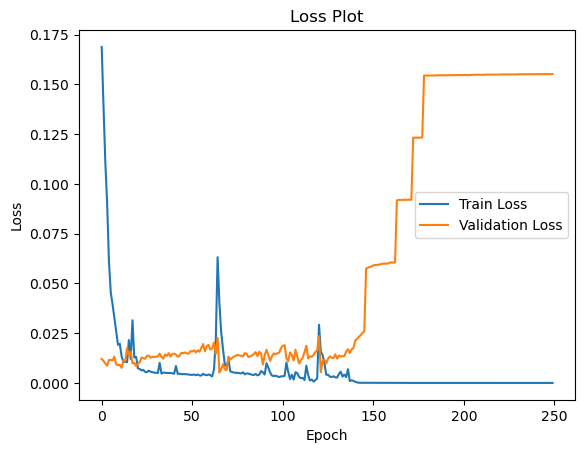

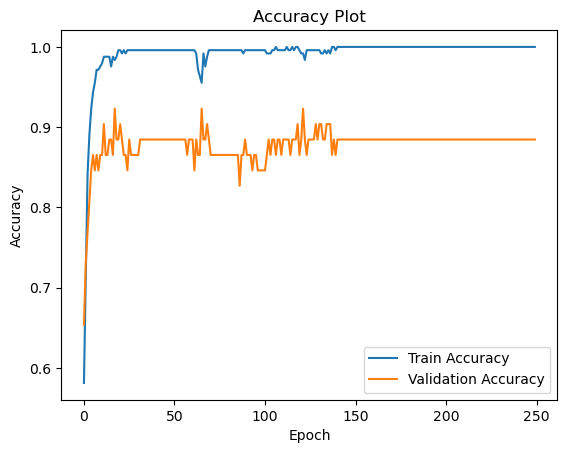

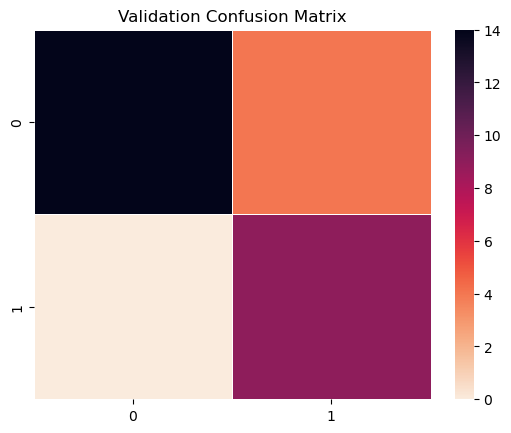

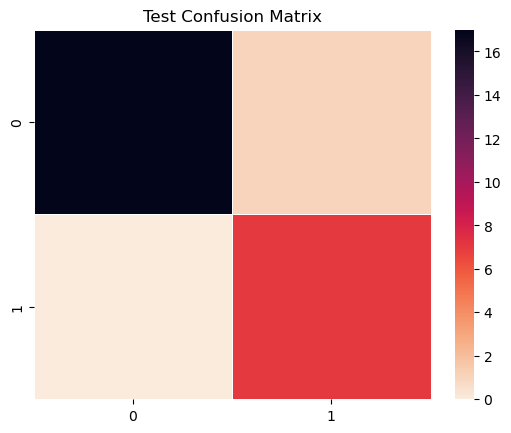

In [2]:
# hyper parameters ########################################################################################
batchSize = 32
epochs = 250
lossFunction = BCELoss
hiddenLayerActivation = ReLU
outputLayerActivation = Sigmoid
model = Network()
# optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = Adam(model.parameters(), lr=0.01)
# optimizer = RMSprop(model.parameters(), lr=0.01)
###########################################################################################################




rawData = read_csv('data-classification/ionosphere.data', header=None)
dataset = TorchDataset(rawData)
trainData, validationData, testData = dataset.getDataSplits()
trainDataLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
validationDataLoader = DataLoader(validationData, batch_size=1024, shuffle=False)
testDataLoader = DataLoader(testData, batch_size=1024, shuffle=False)

startTime = time.time()
trainLosses, trainAccuracies, validationLosses, validationAccuracies, validationConfusionMatrix = train(trainDataLoader, validationDataLoader, model)
endTime = time.time()
trainingTime = endTime - startTime
print('Training Time: ' + str(trainingTime))
print()

testAccuracy, testLoss, testConfusionMatrix = evaluate(testDataLoader, model)

print('Talidation Confusion Matrix')
print(validationConfusionMatrix)
print()
print('Test Confusion Matrix')
print(testConfusionMatrix)
print()
print('Test Loss: ' + str(testLoss.item()))
print('Test Accuracy: ' + str(testAccuracy))



plt.plot(range(len(trainLosses)), trainLosses, label = "Train Loss")
plt.plot(range(len(validationLosses)), validationLosses, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()


plt.plot(range(len(trainAccuracies)), trainAccuracies, label = "Train Accuracy")
plt.plot(range(len(validationAccuracies)), validationAccuracies, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()


ax = sns.heatmap( validationConfusionMatrix , linewidth = 0.5 , cmap = 'rocket_r' )
plt.title( "Validation Confusion Matrix")
plt.show()


ax = sns.heatmap( testConfusionMatrix , linewidth = 0.5 , cmap = 'rocket_r' )
plt.title( "Test Confusion Matrix")
plt.show()